# 1 导包

In [1]:
# 从io工具包导入open方法
from io import open
# 用于字符规范化
import unicodedata
# 用于正则化表达式
import re
# 用于随机生成数据
import random
# 用于构建网络结构和函数的torch包
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import math
# torch中预定义的优化方法工具包
from torch import optim

In [ ]:
# 设备选择，可以选择cuda或者cpu上运行
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# 定义起始标志
SOS_token = 0
# 定义结束标志
EOS_token = 1
class Lang():
    def __init__(self, name):
        # name 传入某种语言的名字
        self.name = name
        # 初始化单词到索引的字典
        self.word2index = {}
        # 初始化索引到单词的映射字典, 其中0、1对应的SOS、EOS已经在字典中
        self.index2word = {0: "SOS", 1: "EOS"}
        # 初始化词汇对应数字索引, 从2开始, 因为0, 1已经被占用
        self.n_words = 2

    def addSentence(self, sentence):
        # 添加句子的函数, 将整个句子中所有单词依次添加到字典中
        # 可以使用空格进行分词即可，不需要jieba库
        for word in sentence.split(" "):
            self.addWord(word)

    def addWord(self, word):
        # 添加单词到类内字典, 将单词转为数字
        # 首先判断单词是否已经在字典中
        if word not in self.word2index:
            # 索引值是当前类中单词总量
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1

In [3]:
name = "eng"
sentence = "hello I am Jay"

eng1 = Lang(name)
eng1.addSentence(sentence)
print("word2index: ", eng1.word2index)
print("index2word: ", eng1.index2word)
print("n_words: ", eng1.n_words)

word2index:  {'hello': 2, 'I': 3, 'am': 4, 'Jay': 5}
index2word:  {0: 'SOS', 1: 'EOS', 2: 'hello', 3: 'I', 4: 'am', 5: 'Jay'}
n_words:  6


In [4]:
# 构建时间函数
def timeSince(since):
    # since 代表模型训练开始时间
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)

In [5]:
# 字符规范化
def unicodeToAScii(s):
    return "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn")

def normalizeString(s):
    # 第一步 使字符转变为小写并去除两侧空白符，再调用上面函数转换为ASCII字符串
    s = unicodeToAScii(s.lower().strip())
    # 在.!?前面加空格
    s = re.sub(r"([.!?])", r" \1", s)
    # 使用正则表达式将字符串中不是大小写字母和正常标点符号的全部转化为空格
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [6]:
s1 = "Are you kidding me?"
res = normalizeString(s1)
print(res)

are you kidding me ?


In [7]:
# 读取数据
data_path = "./data/data/eng-fra.txt"
# 读取原始数据并实例化源语言+目标语言的类对象
def readLangs(lang1, lang2):
    # lang1: 源语言名字
    # lang2: 目标语言名字
    # 整个函数返回对应的两个类对象，以及语言对的列表
    lines = open(data_path, encoding="utf-8").read().strip().split("\n")
    # 对lines列表中的句子进行标准化处理，并以\t再次划分, 形成子列表
    pairs = [[normalizeString(s) for s in l.split("\t")] for l in lines]
    # 直接初始化两个类对象
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    return input_lang, output_lang, pairs

In [8]:
lang1 = "eng"
lang2 = "fra"
input_lang, output_lang, pairs = readLangs(lang1, lang2)
print(f"input_lang: {input_lang}")
print(f"output_lang: {output_lang}")
print(f"pairs: {pairs[: 5]}")

input_lang: <__main__.Lang object at 0x0000025CCCF505B0>
output_lang: <__main__.Lang object at 0x0000025CCD1C6370>
pairs: [['go .', 'va !'], ['run !', 'cours !'], ['run !', 'courez !'], ['wow !', 'ca alors !'], ['fire !', 'au feu !']]


## 过滤符合要求的语言对

In [9]:
# 设置组成句子中单词或标点的最多个数
MAX_LENGTH = 10
# 选择带有指定前缀的语言特征数据作为训练数据
eng_profixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ", 
    "they are", "they re "
)

# 过滤语言对的具体逻辑函数
def filterPair(pair):
    # 当前传入的pair是语言对的形式
    # pair[0] 代表英文源语句，长度且指定前缀
    # pair[1] 代表法文
    return len(pair[0].split(" ")) < MAX_LENGTH and pair[0].startswith(eng_profixes) and len(pair[1].split(" ")) < MAX_LENGTH
# 过滤语言对的函数
def filterPairs(pairs):
    # 函数直接遍历列表中的每个语言字符串并调用filterPairs函数即可
    return [pair for pair in pairs if filterPair(pair)]

In [10]:
fpairs = filterPairs(pairs)
print("过滤后的pairs前五个:", fpairs[:5])


过滤后的pairs前五个: [['i m .', 'j ai ans .'], ['i m ok .', 'je vais bien .'], ['i m ok .', 'ca va .'], ['i m fat .', 'je suis gras .'], ['i m fat .', 'je suis gros .']]


In [11]:
# 整合数据预处理的函数
# def prepareData(lang1, lang2):
#     input_lang, output_lang, pairs = readLangs(lang1, lang2)
#     # 对字符串类型列表进行过滤
#     pairs = filterPairs(pairs)
#     # 对过滤后的列表进行遍历操作，添加到类对象
#     for pair in pairs:
#         input_lang.addSentence(pair[0])
#         output_lang.addSentence(pair[1])
#         # 返回数值映射后的类对象以及过滤后的语言对列表
#     return input_lang, output_lang, pairs

def prepareData(lang1, lang2):
    """数据准备函数, 完成将所有字符串数据向数值型数据的映射以及过滤语言对
       参数lang1, lang2分别代表源语言和目标语言的名字"""
    # 首先通过readLangs函数获得input_lang, output_lang对象，以及字符串类型的语言对列表
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    # 对字符串类型的语言对列表进行过滤操作
    pairs = filterPairs(pairs)
    # 对过滤后的语言对列表进行遍历
    for pair in pairs:
        # 并使用input_lang和output_lang的addSentence方法对其进行数值映射
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    # 返回数值映射后的对象, 和过滤后语言对
    return input_lang, output_lang, pairs


In [12]:
input_lang, output_lang, pairs = prepareData("eng", "fra")
print("input_lang: ", input_lang.n_words)
print("output_lang: ", output_lang.n_words)
print(random.choice(pairs))

input_lang:  2803
output_lang:  4345
['he s too slow .', 'il est trop lent .']


In [13]:
# 将语言对转化为模型输入需要的张量
def tensorsFromSentence(lang, sentence):
    # lang: 传入的Lang实例化对象
    # sentence: 传入的语句
    indexs = [lang.word2index[word] for word in sentence.split(" ")]
    # 要在列表最后添加结束标志
    indexs.append(EOS_token)
    # 将其封装成torch.tensor类型，并改变形状为n*1
    return torch.tensor(indexs,dtype=torch.long).view(-1, 1)


def tensorsFromPair(pair):
    # pair: 代表一个语言对(英文, 法文)
    # 依次调用具体的处理函数，分别处理源语言和目标语言
    input_tensor = tensorsFromSentence(input_lang, pair[0])
    output_tensor = tensorsFromSentence(output_lang, pair[1])
    return (input_tensor, output_tensor)

In [15]:
pair_tensor = tensorsFromPair(pairs[0])
print(pairs[0])
print(f"编码: {pair_tensor}")
print(len(pairs[0]))
print(pair_tensor[0][0])

['i m .', 'j ai ans .']
编码: (tensor([[2],
        [3],
        [4],
        [1]]), tensor([[2],
        [3],
        [4],
        [5],
        [1]]))
2
tensor([2])


# 构建基于GRU的编码器和解码器

In [15]:
class EncodeRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        # input_size 代表编码器输入尺寸，即英文的词表大小
        # hidden_size 代表GRU隐层维度、词嵌入维度
        super(EncodeRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # 示例化Embedding层, 输入参数是 词表单词总数和词嵌入维度
        self.embedding = nn.Embedding(input_size, hidden_size)
        # 实例化GRU
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input1, hidden):
        # 经过embedding处理后，张量是一个二维张量，GRU要求是一个三维张量，因此需要扩展维度可以使用view处理, 同时让任意单词映射后的尺寸是[1, embedding]
        output = self.embedding(input1).view(1, 1, -1)
        # print(f"embedding: {output.shape}")
        # 将output传入GRU单元中
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        # 将隐层张量初始化: [1, 1, hidden_size]
        return torch.zeros(1, 1, self.hidden_size)

In [16]:
hidden_size = 25
input_size = 20
input1 = pair_tensor[0][0]
hidden = torch.zeros(1, 1, hidden_size)

In [17]:
encoder = EncodeRNN(input_size, hidden_size)
output, hidden = encoder(input1, hidden)
print(f"input1: {input1}")
print(output.shape)

input1: tensor([2])
torch.Size([1, 1, 25])


## 解码器

In [18]:
class DecodeRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        # hidden_size: 代表隐层维度, 解码器输入尺寸
        # output_size 代表整个解码器的输出尺寸, 指定的尺寸也就是目标语言的单词总数
        super(DecodeRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        # 实例化Embedding对象
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        # 实例化线性层.线性变换得到希望的输出尺寸
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input1, hidden):
        output = self.embedding(input1).view(1, 1, -1)
        # 使用relu函数处理，使得Embedding矩阵更稀疏，防止过拟合
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        # print(f"gru处理后的维度: {output.shape}")
        # 经过gru处理后是三维张量，但是全连接层处理的是二维张量，因此需要降维
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden)

In [19]:
hidden_size = 10
output_size = 10
input1 = pair_tensor[1][0]
hidden = torch.zeros(1, 1, hidden_size)

In [20]:
decoder = DecodeRNN(hidden_size, output_size)
output, hidden = decoder(input1, hidden)
print(output.shape)

torch.Size([1, 10])


## 基于GRU和Attentional机制的解码器

In [18]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        # hidden_size: 解码器的gru输出尺寸
        # output_size: 指定的网络输出尺寸, 目标语言的词汇总数
        # dropout_p: Dropout
        # max_length: 句子最大尺度
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # 实例化Embedding层，参数是两个: 目标语言词汇总数、词嵌入维度
        self.embedding = nn.Embedding(output_size, hidden_size)
        # 实例化第一个注意力层, 注意输入是两个张量的合并
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        # 实例化第二个注意力层, 注意输入是两个张量合并,然后进入gru
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        # 实例化Drop
        self.dropout = nn.Dropout(self.dropout_p)
        # 实例化gru
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        # 实例化之后的线性层,作为整个解码器输出
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input1, hidden, encoder_output):
        # input1 代表原数据输入张量
        # hidden: 初始化隐层维度
        # encoder_output: 编码器输出张量
        # 对输入的 input1进行词嵌入处理,并扩展维度
        embeded = self.embedding(input1).view(1, 1, -1)
        embeded = self.dropout(embeded)
        print(f"输出 embeded 形状: {embeded.shape}")
        print(f"输出hidden: {hidden.shape}")
        # 进入注意力层
        # 进行第一个注意力层处理前,将QK进行纵轴拼接
        attn_weights =F.softmax(self.attn(torch.cat((embeded[0], hidden[0]), 1)), dim=1)
        print(f"attn_weights形状: {attn_weights.shape}")
        # 进行bmm操作, 注意将二维张量扩展为三维
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_output.unsqueeze(0))

        # 再次拼接, 顺降维
        output = torch.cat((embeded[0], attn_applied[0]), 1)
        # 将 output 输入到第二个注意力层
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        # 激活后的张量连同隐层张量传入gru
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [19]:
hidden_size = 25
output_size = 10
input1 = pair_tensor[1][0]
hidden = torch.zeros(1, 1, hidden_size)
encoder_output = torch.randn(10, 25)
decoder_attn = AttnDecoderRNN(hidden_size, output_size)
output, hidden, attn_weights = decoder_attn(input1, hidden, encoder_output)
print(f"input1: {input1.shape}")
print(f"encoder_output: {encoder_output.shape}")
print(output.shape)
print(hidden.shape)
print(attn_weights.shape)

输出 embeded 形状: torch.Size([1, 1, 25])
输出hidden: torch.Size([1, 1, 25])
attn_weights形状: torch.Size([1, 10])
input1: torch.Size([1])
encoder_output: torch.Size([10, 25])
torch.Size([1, 10])
torch.Size([1, 1, 25])
torch.Size([1, 10])


## 构建训练函数

In [31]:
# 设定teacher_forcing的比率，在多大的概率下使用这个策略训练
teacher_forcing_ratio = 0.5
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    """
    input_tensor: 代表源语言的输入张量
    target_tensor: 代表目标语言的输入张量
    encoder: 代表编码器的实例化对象
    decoder: 代表解码器的实例化对象
    encoder_optimizer: 编码器优化器
    dencoder_optimizer: 解码器优化器
    criterion: 损失函数
    max_length: 句子的最大长度
    """
    # 初始化隐藏层张量
    encoder_hidden = encoder.initHidden()
    # 训练前将编码器和优化器梯度归0
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # 根据源文本和目标文本张量获得对应的长度
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # 初始化编码器的输出矩阵，形如 [max_length * encoder.hidden_size]
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

    # 设置初始损失值
    loss = 0

    # 遍历输入张量
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # 每一次的输出 encoder_output的输出是三维张量, 使用[0, 0]降维到一维列表，赋值给输出张量
        encoder_outputs[ei] = encoder_output[0, 0]

    # 初始化解码器的第一个输入字符
    decoder_input = torch.tensor([[SOS_token]])
    # 初始化解码器的隐层张量, 赋值给最后一次编码器的隐层张量
    decoder_hidden = encoder_hidden

    # 是否使用 teacher_forcing
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # 如果使用 teacher_forcing
    if use_teacher_forcing:
        # 遍历目标张量进行解码
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # 使用损失函数计算损失值
            loss += criterion(decoder_output, target_tensor[di])
            # 由于使用 teacher_forcing，故而将下一步的输入强制设定为"正确答案"
            decoder_input = target_tensor[di]

    # 如果不使用teacher_forcing
    else:
        # 遍历张量解码
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # 预测值变成输出张量中概率最大的
            topv, topi = decoder_output.topk(1)
            # 使用损失函数累加
            loss += criterion(decoder_output, target_tensor[di])
            # 若某一步解码结果是句子终止符号，则解码直接结束
            if topi.squeeze().item() == EOS_token:
                break
            decoder_input = topi.squeeze().detach()

    # 反向传播
    loss.backward()
    # 利用编码器和解码器优化器参数更新
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length

In [32]:
# 打印训练日志
# 导入plt以便绘制损失曲线
import matplotlib.pyplot as plt

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    """训练迭代函数, 输入参数有6个，分别是encoder, decoder: 编码器和解码器对象，
       n_iters: 总迭代步数, print_every:打印日志间隔, plot_every:绘制损失曲线间隔, learning_rate学习率"""
    # 获得训练开始时间戳
    start = time.time()
    # 每个损失间隔的平均损失保存列表，用于绘制损失曲线
    plot_losses = []

    # 每个打印日志间隔的总损失，初始为0
    print_loss_total = 0  
    # 每个绘制损失间隔的总损失，初始为0
    plot_loss_total = 0  

    # 使用预定义的SGD作为优化器，将参数和学习率传入其中
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    # 选择损失函数
    criterion = nn.NLLLoss()

    # 根据设置迭代步进行循环
    for iter in range(1, n_iters + 1):
        # 每次从语言对列表中随机取出一条作为训练语句
        training_pair = tensorsFromPair(random.choice(pairs))
        # 分别从training_pair中取出输入张量和目标张量
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        # 通过train函数获得模型运行的损失
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        # 将损失进行累和
        print_loss_total += loss
        plot_loss_total += loss

        # 当迭代步达到日志打印间隔时
        if iter % print_every == 0:
            # 通过总损失除以间隔得到平均损失
            print_loss_avg = print_loss_total / print_every
            # 将总损失归0
            print_loss_total = 0
            # 打印日志，日志内容分别是：训练耗时，当前迭代步，当前进度百分比，当前平均损失
            print('%s (%d %d%%) %.4f' % (timeSince(start),
                                         iter, iter / n_iters * 100, print_loss_avg))

        # 当迭代步达到损失绘制间隔时
        if iter % plot_every == 0:
            # 通过总损失除以间隔得到平均损失
            plot_loss_avg = plot_loss_total / plot_every
            # 将平均损失装进plot_losses列表
            plot_losses.append(plot_loss_avg)
            # 总损失归0
            plot_loss_total = 0

    # 绘制损失曲线
    plt.figure()  
    plt.plot(plot_losses)
    # 保存到指定路径
    plt.savefig("./s2s_loss.png")


In [34]:
# 设置隐层大小为256 ，也是词嵌入维度      
hidden_size = 256
# 通过input_lang.n_words获取输入词汇总数，与hidden_size一同传入EncoderRNN类中
# 得到编码器对象encoder1
encoder1 = EncodeRNN(input_lang.n_words, hidden_size)

# 通过output_lang.n_words获取目标词汇总数，与hidden_size和dropout_p一同传入AttnDecoderRNN类中
# 得到解码器对象attn_decoder1
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)

# 设置迭代步数 
n_iters = 13000
# 设置日志打印间隔
print_every = 500


1m 1s (500 3%) 4.2725
2m 5s (1000 7%) 3.7417
3m 8s (1500 11%) 3.5464
4m 11s (2000 15%) 3.4867
5m 13s (2500 19%) 3.3409
6m 17s (3000 23%) 3.2846
7m 21s (3500 26%) 3.2149
8m 27s (4000 30%) 3.1602
9m 30s (4500 34%) 3.0440
10m 35s (5000 38%) 3.0399
11m 39s (5500 42%) 2.8851
12m 43s (6000 46%) 2.9064
13m 48s (6500 50%) 2.9558
14m 52s (7000 53%) 2.8467
15m 56s (7500 57%) 2.8619
17m 1s (8000 61%) 2.7900
18m 5s (8500 65%) 2.7637
19m 9s (9000 69%) 2.6287
20m 13s (9500 73%) 2.6932
21m 17s (10000 76%) 2.6209
22m 21s (10500 80%) 2.6357
23m 28s (11000 84%) 2.5604
24m 33s (11500 88%) 2.4735
25m 37s (12000 92%) 2.4902
26m 40s (12500 96%) 2.4107
27m 44s (13000 100%) 2.4786


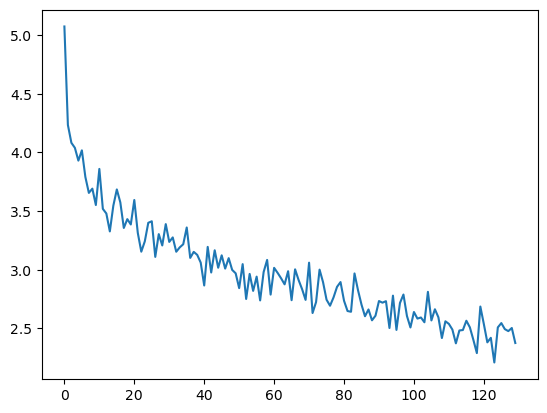

In [35]:
# 调用trainIters进行模型训练，将编码器对象encoder1，码器对象attn_decoder1，迭代步数，日志打印间隔传入其中
trainIters(encoder1, attn_decoder1, n_iters, print_every=print_every)


In [36]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    # encoder: 编码器对象
    # decoder: 解码器对象
    # sentence: 待评估的原语句
    # max_length: 句子最大长度
    # 注意: 这个评估过程梯度不改变
    with torch.no_grad():
        # 对输入语句张量表示
        input_tensor = tensorsFromSentence(input_lang, sentence)
        # 获得输入句子长度
        input_length = input_tensor.size(0)
        # 初始化编码器的隐层张量
        encoder_hidden = encoder.initHidden()
        # 初始化编码器输出张量, 矩阵形状: [max_length * hidden_size]
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

        # 遍历输入张量
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            # 将三维张量的输出先降维到一维、赋值给 encoder_outputs
            encoder_outputs[ei] = encoder_output[0, 0]

        # 初始化解码器的第一个输入，就是起始字符
        decoder_input = torch.tensor([[SOS_token]])
        # 初始化解码器隐层输入
        decoder_hidden = encoder_hidden
        # 初始化预测词汇的列表
        decoder_words = []
        # 初始化一个attention张量
        decoder_attentions = torch.zeros(max_length, max_length)

        # 遍历解码
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # 首先将注意力张量保存
            decoder_attentions[di] = decoder_attention.data
            # 按照解码器输出最高概率作为当前时间步的预测值
            topv, topi = decoder_output.data.topk(1)
            # 如果解析出的是结束字符
            if topi.item == EOS_token:
                # 将结束字符添加到结果列表中，并退出解码循环
                decoder_words.append("<EOS>")
                break
            else:
                # 根据索引去将真实的字符添加进结果列表中
                decoder_words.append(output_lang.index2word[topi.item()])

            # 最后一步将预测的标签赋值给下一步的解码输入
            decoder_input = topi.squeeze().detach()
        # 返回最终解码的结果列表, 以及注意力张量
        return decoder_words, decoder_attentions[:di + 1]

In [37]:
# 随机选择指定数量数据评估
def evaluateRandomly(encoder, decoder, n=6):
    for i in range(n):
        pair = random.choice(pairs)
        print(f"> {pair[0]}")
        print(f"= {pair[1]}")
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = " ".join(output_words)
        print(f"< {output_sentence}")
        print(" ")

In [38]:
evaluateRandomly(encoder1, attn_decoder1)

> he is always making a fool of me .
= il se moque toujours de moi .
< il est le a moi . EOS . EOS .
 
> i m glad to hear that .
= je suis heureux d entendre cela .
< je me rejouis de l EOS . EOS . EOS
 
> i am out of work .
= je suis au chomage .
< je suis a l . . EOS . EOS .
 
> you re ambitious .
= vous etes ambitieuses .
< tu es ! . EOS . EOS . EOS .
 
> you re a nerd .
= tu es un binoclard .
< tu es un menteur . EOS . EOS . EOS
 
> we re paying .
= nous sommes en train de payer .
< nous sommes en . EOS . EOS . EOS .
 


['nous', 'sommes', 'tous', '.', 'EOS', '.', 'EOS', '.', 'EOS', '.']


<Figure size 640x480 with 0 Axes>

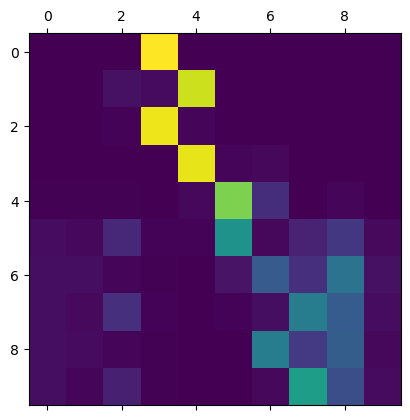

In [37]:
# 注意力可视化
sentence = "we are both teachers ."
output_words, attention = evaluate(encoder1, attn_decoder1, sentence)
print(output_words)
plt.figure()
plt.matshow(attention.numpy())

In [14]:
re.sub(r"(ab)c(ert)f", r"\1A", "abcabcertf")

'abcabA'

In [38]:
import argparse

In [39]:
import json

In [51]:
import tkinter
print(tkinter.TkVersion)

8.6
